In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.special as special
import numpy.linalg as la
from numpy import fft
from scipy.linalg import solve



Gaus, ga par razlicnih parametrov, transformacija z anlitično resitvijo, z eulerjem in rk4, primerjava z analitično rešitvijo, animacija, lah zrises temperaturni profil, obmocje stabilnosti za eulerja, transformacije za razlicne funkcije, casovna zahtevnost v odvisnosti od N, 

/Users/lukapuslar/miniconda3/envs/torch_m1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


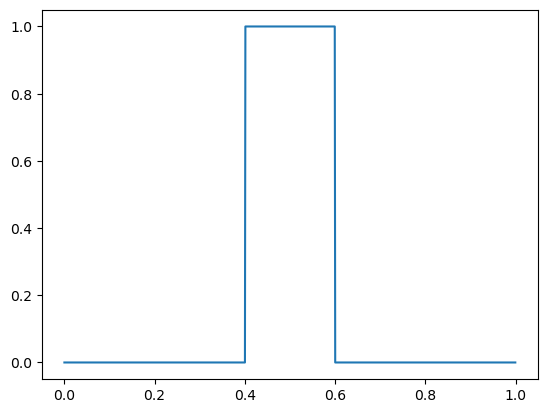

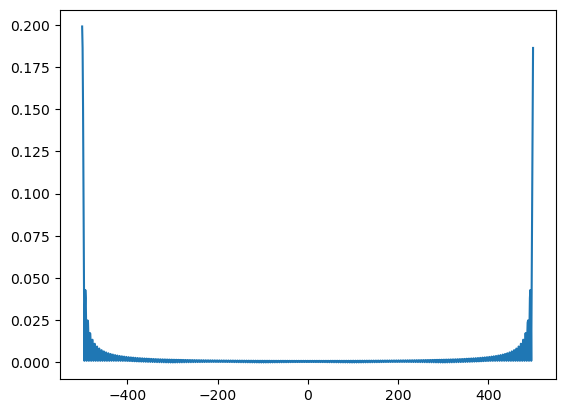

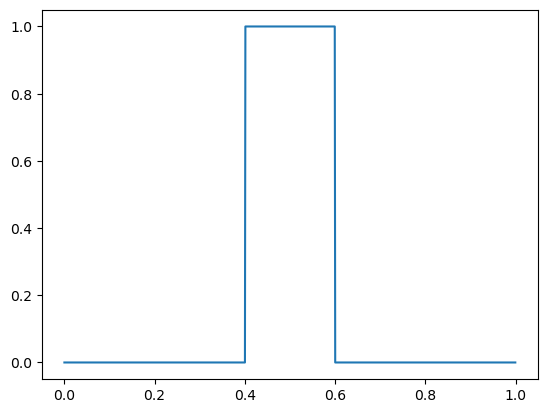

In [50]:
N = 1000
L = 1
x = np.arange(0,1,0.001)
D = 1  
delta=L/N
T0 = np.zeros(len(x))
T0[np.where((x>0.4) & (x<0.6))] = 1
plt.plot(x,T0)

nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
nu = fft.fftshift(nu) # Shift frequencies to match fft
T0_hat = fft.fft(fft.ifftshift(T0))/N # Fourier coefficients (divided by n), correctly shifted
T0 = fft.ifftshift(fft.ifft(T0_hat))*N # Recreate the function from the fourier coefficients
plt.figure()
plt.plot(nu,abs(T0_hat))
plt.figure()
plt.plot(x,T0)

In [422]:
# mpl.rcParams.update({
#     'font.family': 'serif',
#     'text.usetex': True,
#     'axes.labelsize': 'large',
#     'figure.dpi': 100,
# })
# mpl.rcParams.update({})

mpl.rcdefaults()


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/2022396674.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


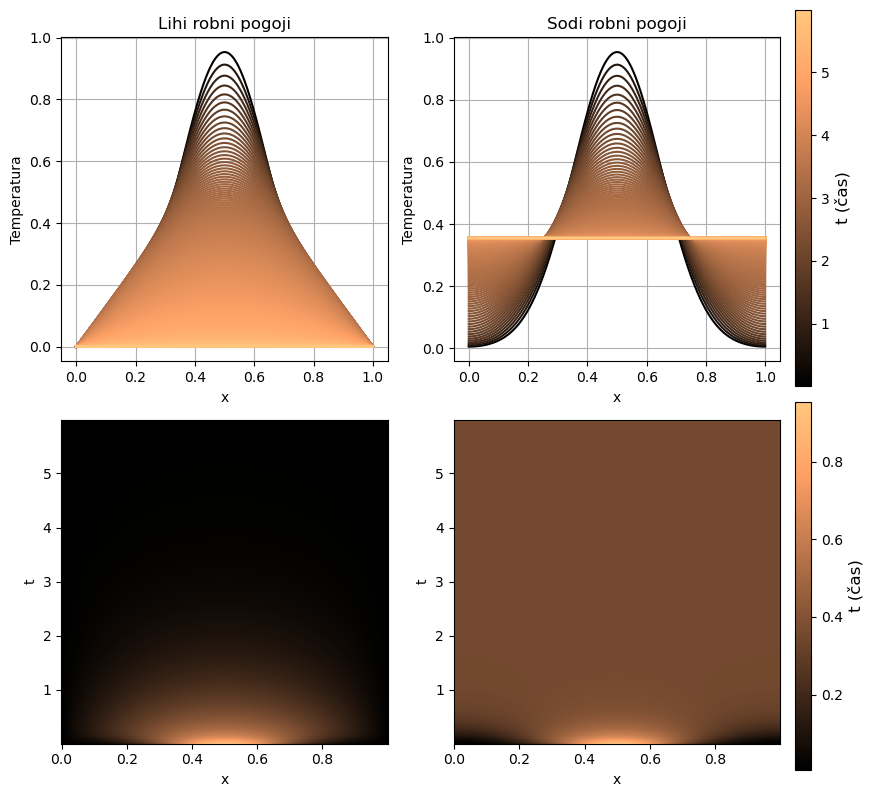

In [26]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        # T_0 = fft.fft(fft.ifftshift(T_0))/N # Fourier coefficients (divided by n), correctly shifted
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    # norm = Normalize(vmin=min(t), vmax=max(t))
    norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
    cks = []
    colors = []
    Ts = []
    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        cks.append(ck)
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
    return Ts, cks, colors



N = 1000
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)

def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,6,0.01)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

#lihi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, colors = res
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=colors[ind])
fontsize=12)

pcm = axs[1,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))


#sodi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts[ind],color=colors[ind])
cax = fig.add_axes([1.0, 0.52, 0.02, 0.47])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.04, 0.02, 0.46])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

axs[0,0].set_title("Lihi robni pogoji")
axs[0,1].set_title("Sodi robni pogoji") 
axs[0,0].set_ylabel("Temperatura")
axs[0,1].set_ylabel("Temperatura")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[1,0].set_ylabel("t")
axs[1,1].set_ylabel("t")
axs[0,0].grid()
axs[0,1].grid()


# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
plt.savefig("lihi_sodi_rp_jupyter_1", bbox_inches="tight")



/Users/lukapuslar/miniconda3/envs/torch_m1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3853791082.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


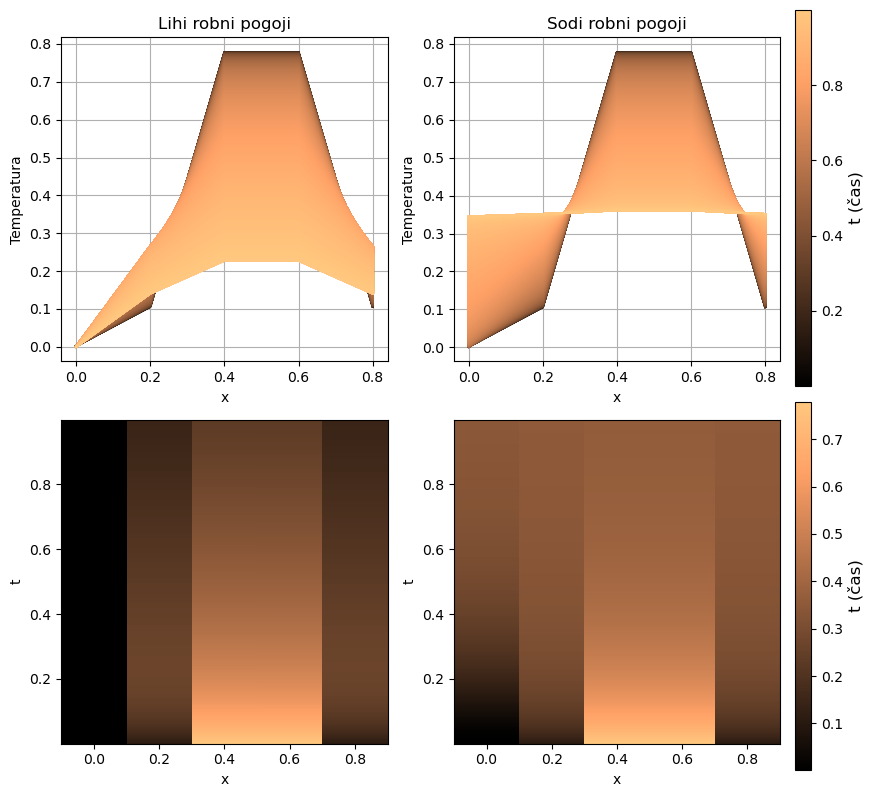

In [77]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        # T_0 = fft.fft(fft.ifftshift(T_0))/N # Fourier coefficients (divided by n), correctly shifted
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    # norm = Normalize(vmin=min(t), vmax=max(t))
    norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
    cks = []
    colors = []
    Ts = []
    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        cks.append(ck)
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
    return Ts, cks, colors



N = 5
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)

def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,1,0.0001)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

#lihi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, colors = res
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=colors[ind])

pcm = axs[1,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))

#sodi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts[ind],color=colors[ind])
cax = fig.add_axes([1.0, 0.52, 0.02, 0.47])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.04, 0.02, 0.46])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

axs[0,0].set_title("Lihi robni pogoji")
axs[0,1].set_title("Sodi robni pogoji") 
axs[0,0].set_ylabel("Temperatura")
axs[0,1].set_ylabel("Temperatura")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[1,0].set_ylabel("t")
axs[1,1].set_ylabel("t")
axs[0,0].grid()
axs[0,1].grid()


# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
# plt.savefig("lihi_sodi_rp", bbox_inches="tight")



3


/Users/lukapuslar/miniconda3/envs/torch_m1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4
5
6
7
8
9


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3517859578.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


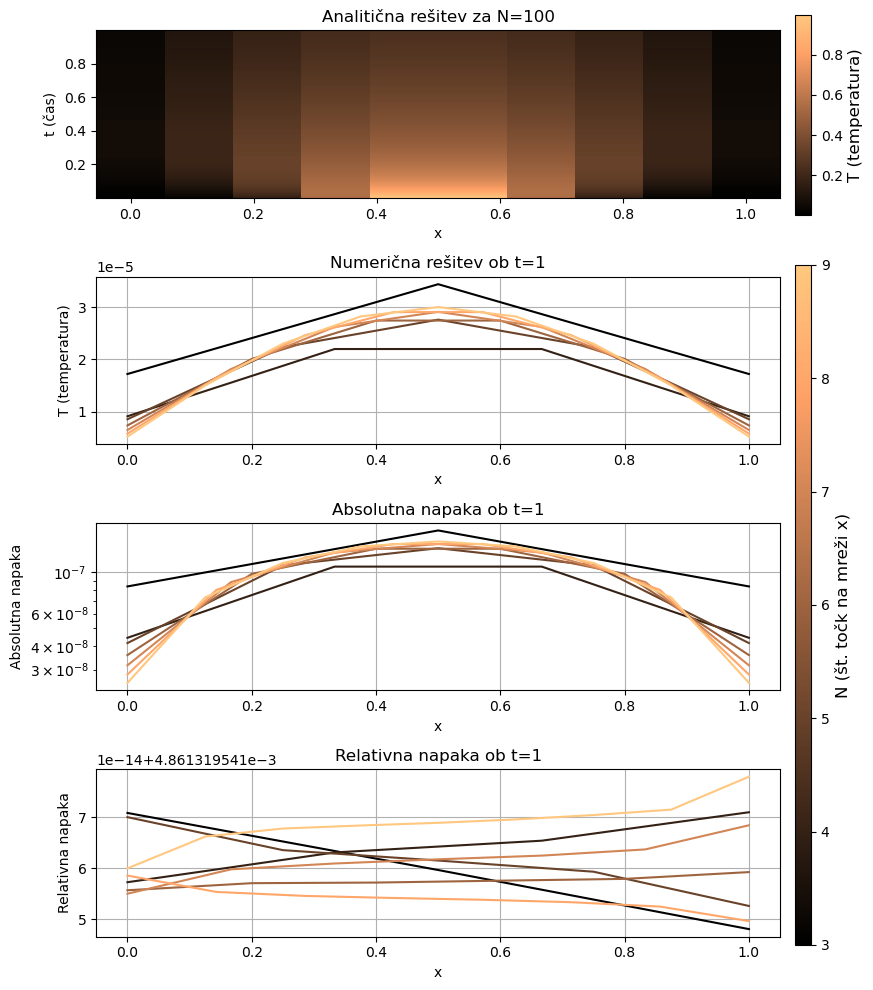

In [80]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    colors = []
    Ts = []

    # #RK4
    # def df(x, t):
    #     return -4 * np.pi**2 * D * fk**2 * x

    # cks = rku4(df, T0_hat, t)
    # # print(np.shape(cks))

    #EULER
    cks = []
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)
    
    # print(np.shape(ck))
    # print(np.shape(t))

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck[ind])
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
        # plt.plot(,x,T,color=color)

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck)
        # colors.append(color)
        Ts_a.append(T)

    #     # plt.plot(x,T,color=color)
    return Ts, colors, Ts_a



N = 40
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)
# plt.plot(x,T_0)


fig, ax = plt.subplots(4, 1, figsize=(8, 10))


t = np.arange(0,1,0.0001)
Ns = np.arange(3,6,1)
Ns = np.arange(3,10,1)

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
for N in Ns:
    print(N)
    L = 1
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
    D = 1  
    T_0 = np.zeros(N)
    T_0[np.where((x>0.4) & (x<0.6))] = 1
    T_0 = np.sin(2*np.pi *x)
    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)
    T_0 = gauss(x,0.5*L,0.2,1)

    res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
    Ts, colors, Ts_a = res
    # print(np.max(np.abs(Ts)))
    color = cmap(norm(N))
    # ax[0].plot(x,Ts_a[-1],color=color)
    ax[1].plot(x,Ts[-1],color=color)
    ax[2].plot(x,np.abs(Ts_a[-1] - Ts[-1]),color=color)
    ax[3].plot(x,np.abs(Ts_a[-1] - Ts[-1])/np.abs(Ts_a[-1]),color=color)

    # print(np.max(Ts[-1])- np.max(Ts_a[-1]))
    # if np.max(Ts) > 5:
    #     print('div: ', N)



N = 10
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
# T_0 = np.zeros(N)
# T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)

T_0 = gauss(x,0.5*L,0.2,1)

res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, Ts_a = res
# Ts = Ts[0]
# print(np.shape(Ts), np.shape(t), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
# for ind,ti in enumerate(t[1:]):
#     ax[0].plot(x,np.real(Ts[ind]),color=cmap(norm(ti)))
pcm = ax[0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 

cax = fig.add_axes([1.0, 0.78, 0.02, 0.20])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[0],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)



ax[2].set_yscale('log')
ax[0].set_title("Analitična rešitev za N=100")
ax[1].set_title("Numerična rešitev ob t=1")
ax[2].set_title("Absolutna napaka ob t=1")
ax[0].set_ylabel("t (čas)")
ax[1].set_ylabel("T (temperatura)")
ax[2].set_ylabel(r"Absolutna napaka")
ax[2].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_xlabel("x")
ax[3].set_xlabel("x")
ax[3].set_ylabel(r"Relativna napaka")
# ax[3].set_yscale('log')
ax[3].set_title("Relativna napaka ob t=1")
ax[3].grid()
# ax[0].grid()
ax[1].grid()
ax[2].grid()
cax = fig.add_axes([1.0, 0.05, 0.02, 0.68])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[1],location='right')
cbar.set_label(r'N (št. točk na mreži x)', fontsize=12)
plt.tight_layout()
# plt.savefig('euler', bbox_inches="tight")



    



In [52]:

def rku4( f, x0, t ):
    """Fourth-order Runge-Kutta method to solve x' = f(x,t) with x(t[0]) = x0.

    USAGE:
        x = rku4(f, x0, t)

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a np array.  In this
                case f must return a np array with the same dimension
                as x.
        x0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or np array
                if a system of equations is being solved.
        t     - list or np array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.

    OUTPUT:
        x     - np array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.
    """

    n = len( t )
    x = np.array( [ x0 ] * n )
    # print(np.shape(x))
    for i in range( n - 1 ):
        # print(t[i+1], t[i])
        h = t[i+1] - t[i]
        k1 = h * f( x[i], t[i] )
        # print(f( x[i], t[i] ))
        # print(h)
        k2 = h * f( x[i] + 0.5 * k1, t[i] + 0.5 * h )
        k3 = h * f( x[i] + 0.5 * k2, t[i] + 0.5 * h )
        k4 = h * f( x[i] + k3, t[i+1] )
        # print( x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0)
        x[i+1] = x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0
    return x


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/4103914215.py:53: RuntimeWarning: overflow encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/4103914215.py:53: RuntimeWarning: invalid value encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/4103914215.py:60: RuntimeWarning: invalid value encountered in multiply
  T = (N * fft.ifft(cks[ind]))


48
49


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/4103914215.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


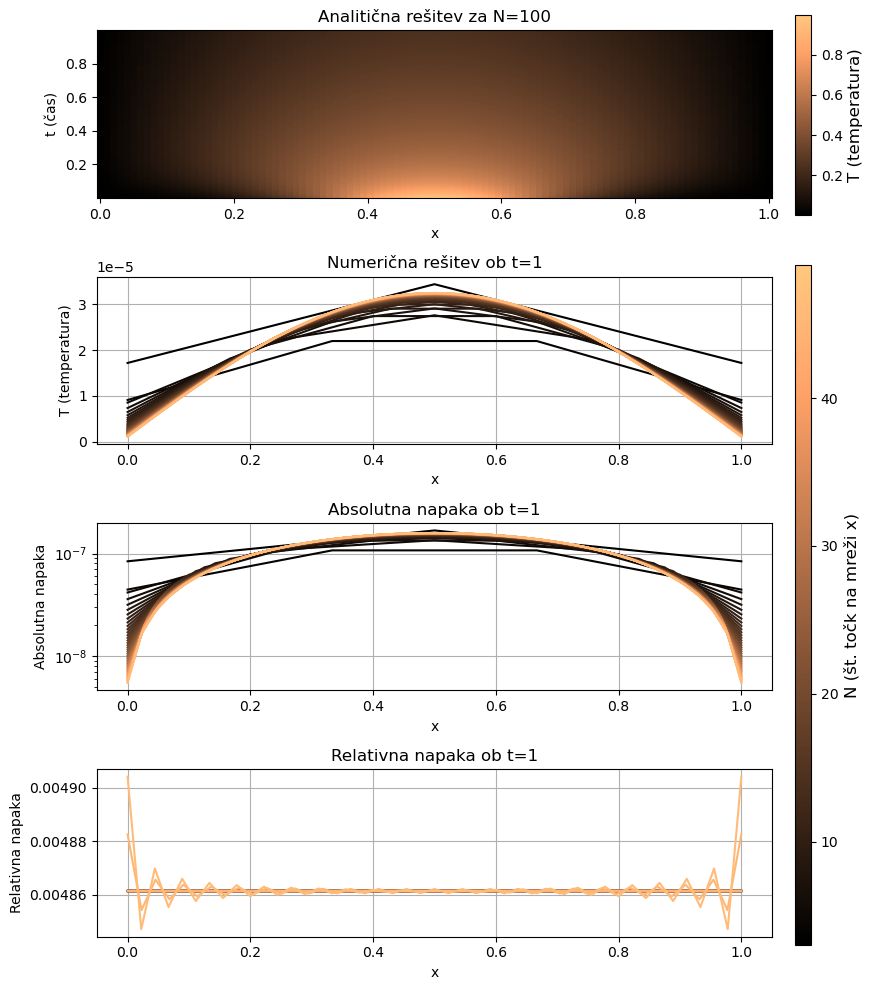

In [59]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    colors = []
    Ts = []

    # #RK4
    # def df(x, t):
    #     return -4 * np.pi**2 * D * fk**2 * x

    # cks = rku4(df, T0_hat, t)
    # # print(np.shape(cks))

    #EULER
    cks = []
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)
    
    # print(np.shape(ck))
    # print(np.shape(t))

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck[ind])
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
        # plt.plot(,x,T,color=color)

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck)
        # colors.append(color)
        Ts_a.append(T)

    #     # plt.plot(x,T,color=color)
    return Ts, colors, Ts_a



N = 40
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)
# plt.plot(x,T_0)


fig, ax = plt.subplots(4, 1, figsize=(8, 10))


t = np.arange(0,1,0.0001)
Ns = np.arange(3,6,1)
Ns = np.arange(3,50,1)

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
for N in Ns:
    print(N)
    L = 1
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
    D = 1  
    T_0 = np.zeros(N)
    T_0[np.where((x>0.4) & (x<0.6))] = 1
    T_0 = np.sin(2*np.pi *x)
    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)
    T_0 = gauss(x,0.5*L,0.2,1)

    res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
    Ts, colors, Ts_a = res
    # print(np.max(np.abs(Ts)))
    color = cmap(norm(N))
    # ax[0].plot(x,Ts_a[-1],color=color)
    ax[1].plot(x,Ts[-1],color=color)
    ax[2].plot(x,np.abs(Ts_a[-1] - Ts[-1]),color=color)
    ax[3].plot(x,np.abs(Ts_a[-1] - Ts[-1])/np.abs(Ts_a[-1]),color=color)

    # print(np.max(Ts[-1])- np.max(Ts_a[-1]))
    # if np.max(Ts) > 5:
    #     print('div: ', N)



N = 100
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
# T_0 = np.zeros(N)
# T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)

T_0 = gauss(x,0.5*L,0.2,1)

res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, Ts_a = res
# Ts = Ts[0]
# print(np.shape(Ts), np.shape(t), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
# for ind,ti in enumerate(t[1:]):
#     ax[0].plot(x,np.real(Ts[ind]),color=cmap(norm(ti)))
pcm = ax[0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 

cax = fig.add_axes([1.0, 0.78, 0.02, 0.20])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[0],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)



ax[2].set_yscale('log')
ax[0].set_title("Analitična rešitev za N=100")
ax[1].set_title("Numerična rešitev ob t=1")
ax[2].set_title("Absolutna napaka ob t=1")
ax[0].set_ylabel("t (čas)")
ax[1].set_ylabel("T (temperatura)")
ax[2].set_ylabel(r"Absolutna napaka")
ax[2].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_xlabel("x")
ax[3].set_xlabel("x")
ax[3].set_ylabel(r"Relativna napaka")
# ax[3].set_yscale('log')
ax[3].set_title("Relativna napaka ob t=1")
ax[3].grid()
# ax[0].grid()
ax[1].grid()
ax[2].grid()
cax = fig.add_axes([1.0, 0.05, 0.02, 0.68])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[1],location='right')
cbar.set_label(r'N (št. točk na mreži x)', fontsize=12)
plt.tight_layout()
plt.savefig('euler', bbox_inches="tight")



    



3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1617777721.py:53: RuntimeWarning: overflow encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1617777721.py:53: RuntimeWarning: invalid value encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1617777721.py:60: RuntimeWarning: invalid value encountered in multiply
  T = (N * fft.ifft(cks[ind]))


47
48
49


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1617777721.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


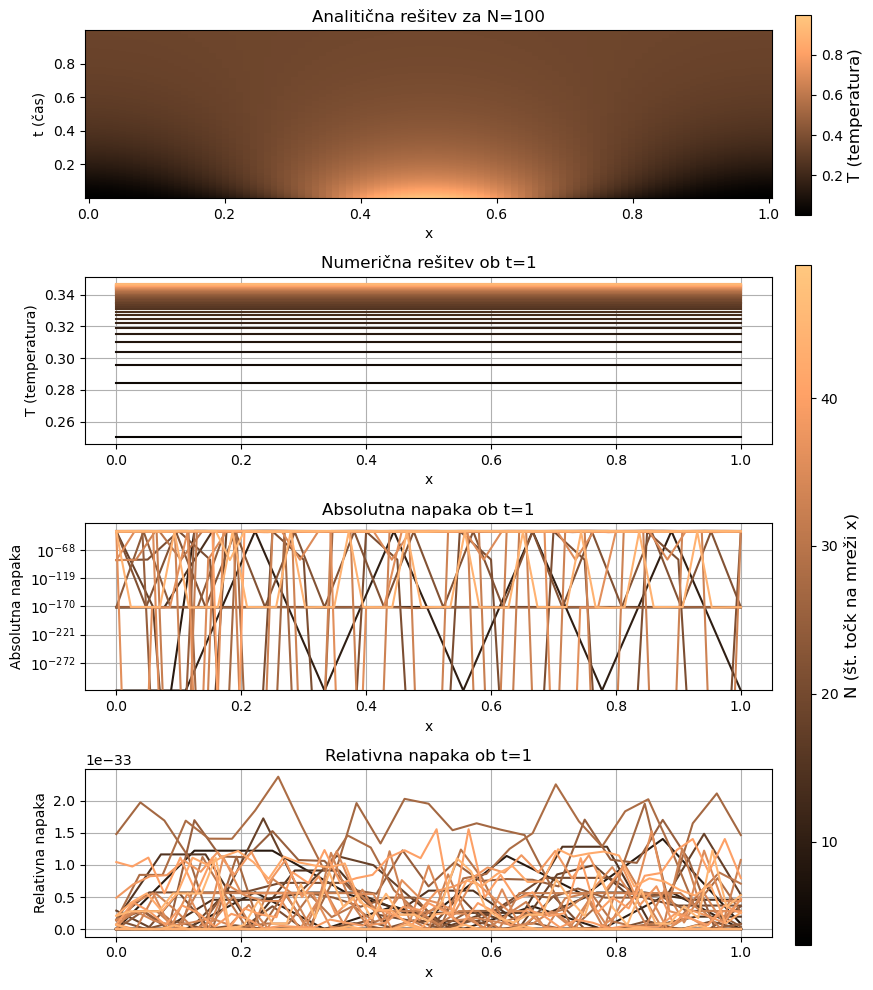

In [66]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    colors = []
    Ts = []

    # #RK4
    # def df(x, t):
    #     return -4 * np.pi**2 * D * fk**2 * x

    # cks = rku4(df, T0_hat, t)
    # # print(np.shape(cks))

    #EULER
    cks = []
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)
    
    # print(np.shape(ck))
    # print(np.shape(t))

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck[ind])
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
        # plt.plot(,x,T,color=color)

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck)
        # colors.append(color)
        Ts_a.append(T)

    #     # plt.plot(x,T,color=color)
    return Ts, colors, Ts_a



N = 40
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)
# plt.plot(x,T_0)


fig, ax = plt.subplots(4, 1, figsize=(8, 10))


t = np.arange(0,1,0.0001)
Ns = np.arange(3,6,1)
Ns = np.arange(3,50,1)

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
for N in Ns:
    print(N)
    L = 1
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
    D = 1  
    T_0 = np.zeros(N)
    T_0[np.where((x>0.4) & (x<0.6))] = 1
    T_0 = np.sin(2*np.pi *x)
    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)
    T_0 = gauss(x,0.5*L,0.2,1)

    res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
    Ts, colors, Ts_a = res
    # print(np.max(np.abs(Ts)))
    color = cmap(norm(N))
    # ax[0].plot(x,Ts_a[-1],color=color)
    ax[1].plot(x,Ts[-1],color=color)
    ax[2].plot(x,np.abs(Ts_a[-1] - Ts[-1]),color=color)
    ax[3].plot(x,np.abs(Ts_a[-1] - Ts[-1])/np.abs(Ts_a[-1]),color=color)

    # print(np.max(Ts[-1])- np.max(Ts_a[-1]))
    # if np.max(Ts) > 5:
    #     print('div: ', N)



N = 100
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
# T_0 = np.zeros(N)
# T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)

T_0 = gauss(x,0.5*L,0.2,1)

res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, Ts_a = res
# Ts = Ts[0]
# print(np.shape(Ts), np.shape(t), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
# for ind,ti in enumerate(t[1:]):
#     ax[0].plot(x,np.real(Ts[ind]),color=cmap(norm(ti)))
pcm = ax[0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 

cax = fig.add_axes([1.0, 0.78, 0.02, 0.20])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[0],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)



ax[2].set_yscale('log')
ax[0].set_title("Analitična rešitev za N=100")
ax[1].set_title("Numerična rešitev ob t=1")
ax[2].set_title("Absolutna napaka ob t=1")
ax[0].set_ylabel("t (čas)")
ax[1].set_ylabel("T (temperatura)")
ax[2].set_ylabel(r"Absolutna napaka")
ax[2].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_xlabel("x")
ax[3].set_xlabel("x")
ax[3].set_ylabel(r"Relativna napaka")
# ax[3].set_yscale('log')
ax[3].set_title("Relativna napaka ob t=1")
ax[3].grid()
# ax[0].grid()
ax[1].grid()
ax[2].grid()
cax = fig.add_axes([1.0, 0.05, 0.02, 0.68])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[1],location='right')
cbar.set_label(r'N (št. točk na mreži x)', fontsize=12)
plt.tight_layout()
plt.savefig('euler_sodi', bbox_inches="tight")



    



3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/2776343259.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


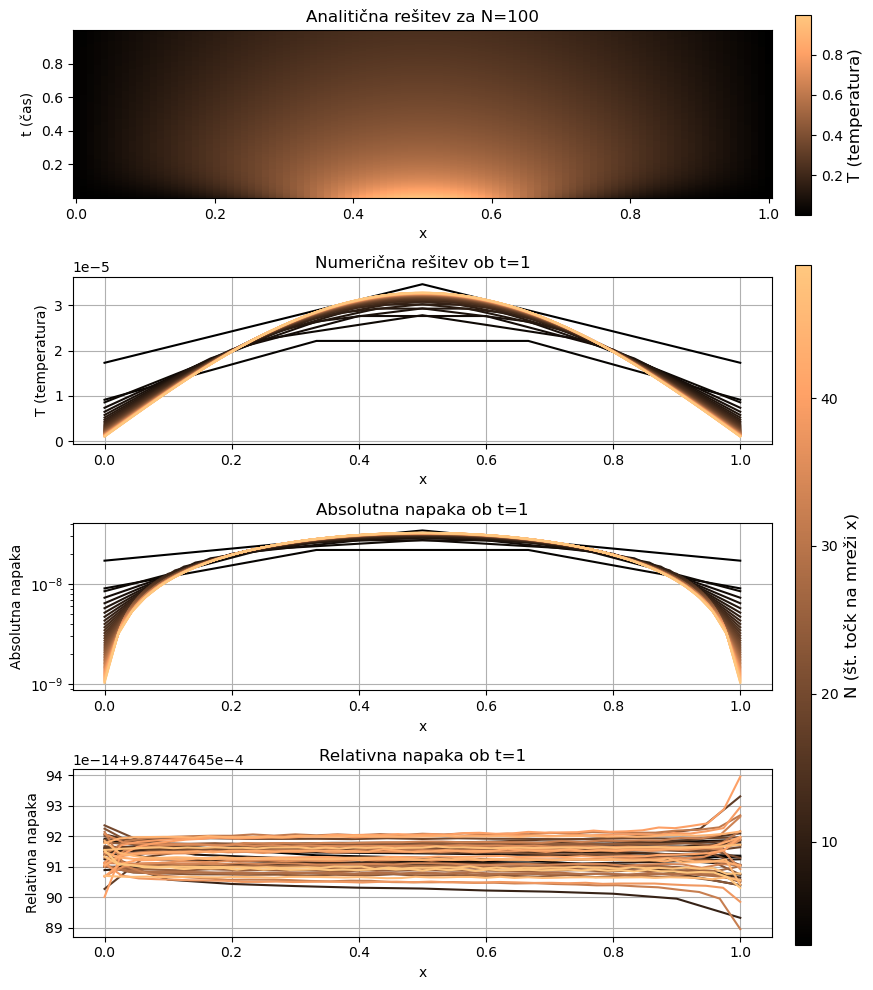

In [62]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    colors = []
    Ts = []

    #RK4
    def df(x, t):
        return -4 * np.pi**2 * D * fk**2 * x

    cks = rku4(df, T0_hat, t)
    # print(np.shape(cks))

    # #EULER
    # cks = []
    # ck = T0_hat
    # # print(np.shape(ck), np.shape(fk))
    # for t1 in t:
    #     ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
    #     cks.append(ck)
    
    # print(np.shape(ck))
    # print(np.shape(t))

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck[ind])
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
        # plt.plot(,x,T,color=color)

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck)
        # colors.append(color)
        Ts_a.append(T)

    #     # plt.plot(x,T,color=color)
    return Ts, colors, Ts_a



N = 40
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)
# plt.plot(x,T_0)


fig, ax = plt.subplots(4, 1, figsize=(8, 10))


t = np.arange(0,1,0.0001)
Ns = np.arange(3,6,1)
Ns = np.arange(3,50,1)

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
for N in Ns:
    print(N)
    L = 1
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
    D = 1  
    T_0 = np.zeros(N)
    T_0[np.where((x>0.4) & (x<0.6))] = 1
    T_0 = np.sin(2*np.pi *x)
    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)
    T_0 = gauss(x,0.5*L,0.2,1)

    res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
    Ts, colors, Ts_a = res
    # print(np.max(np.abs(Ts)))
    color = cmap(norm(N))
    # ax[0].plot(x,Ts_a[-1],color=color)
    ax[1].plot(x,Ts[-1],color=color)
    ax[2].plot(x,np.abs(Ts_a[-1] - Ts[-1]),color=color)
    ax[3].plot(x,np.abs(Ts_a[-1] - Ts[-1])/np.abs(Ts_a[-1]),color=color)

    # print(np.max(Ts[-1])- np.max(Ts_a[-1]))
    # if np.max(Ts) > 5:
    #     print('div: ', N)



N = 100
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
# T_0 = np.zeros(N)
# T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)

T_0 = gauss(x,0.5*L,0.2,1)

res = solve_diffusion(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, Ts_a = res
# Ts = Ts[0]
# print(np.shape(Ts), np.shape(t), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
# for ind,ti in enumerate(t[1:]):
#     ax[0].plot(x,np.real(Ts[ind]),color=cmap(norm(ti)))
pcm = ax[0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 

cax = fig.add_axes([1.00, 0.78, 0.02, 0.20])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[0],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)


ax[2].set_yscale('log')
ax[0].set_title("Analitična rešitev za N=100")
ax[1].set_title("Numerična rešitev ob t=1")
ax[2].set_title("Absolutna napaka ob t=1")
ax[0].set_ylabel("t (čas)")
ax[1].set_ylabel("T (temperatura)")
ax[2].set_ylabel("Absolutna napaka")
ax[2].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_xlabel("x")
ax[3].set_xlabel("x")
ax[3].set_ylabel("Relativna napaka")
# ax[3].set_yscale('log')
ax[3].set_title("Relativna napaka ob t=1")
ax[3].grid()
# ax[0].grid()
ax[1].grid()
ax[2].grid()
cax = fig.add_axes([1.00, 0.05, 0.02, 0.68])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[1],location='right')
cbar.set_label(r'N (št. točk na mreži x)', fontsize=12)
plt.tight_layout()
plt.savefig("RK4", bbox_inches="tight")



    



3


NameError: name 'rku4' is not defined

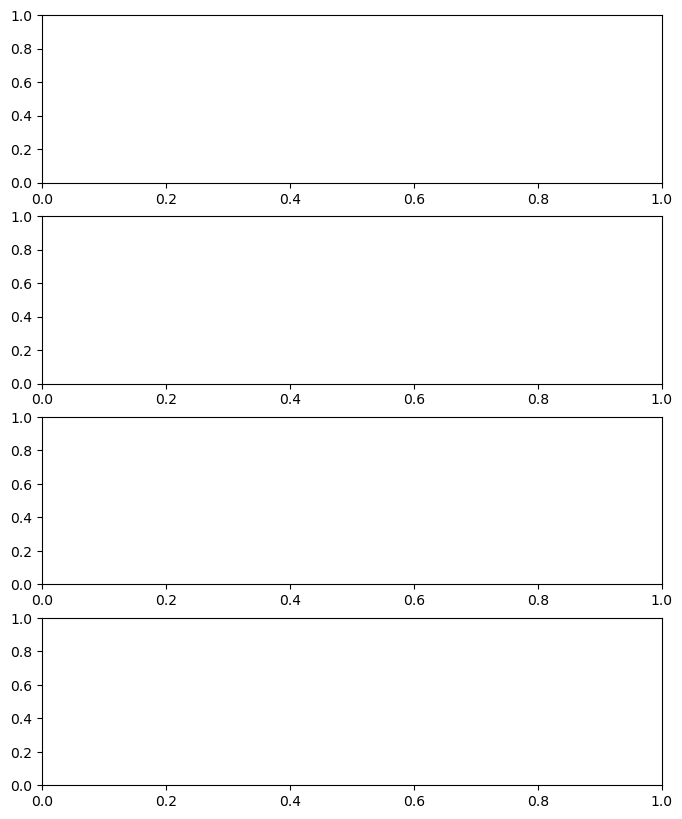

In [37]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    colors = []
    Ts = []

    #RK4
    def df(x, t):
        return -4 * np.pi**2 * D * fk**2 * x

    cks = rku4(df, T0_hat, t)
    # print(np.shape(cks))

    # #EULER
    # cks = []
    # ck = T0_hat
    # # print(np.shape(ck), np.shape(fk))
    # for t1 in t:
    #     ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
    #     cks.append(ck)
    
    # print(np.shape(ck))
    # print(np.shape(t))

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck[ind])
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
        # plt.plot(,x,T,color=color)

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        # cks.append(ck)
        # colors.append(color)
        Ts_a.append(T)

    #     # plt.plot(x,T,color=color)
    return Ts, colors, Ts_a



N = 40
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)
# plt.plot(x,T_0)


fig, ax = plt.subplots(4, 1, figsize=(8, 10))


t = np.arange(0,1,0.0001)
Ns = np.arange(3,6,1)
Ns = np.arange(3,50,1)

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
for N in Ns:
    print(N)
    L = 1
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
    D = 1  
    T_0 = np.zeros(N)
    T_0[np.where((x>0.4) & (x<0.6))] = 1
    T_0 = np.sin(2*np.pi *x)
    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)
    T_0 = gauss(x,0.5*L,0.2,1)

    res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
    Ts, colors, Ts_a = res
    # print(np.max(np.abs(Ts)))
    color = cmap(norm(N))
    # ax[0].plot(x,Ts_a[-1],color=color)
    ax[1].plot(x,Ts[-1],color=color)
    ax[2].plot(x,np.abs(Ts_a[-1] - Ts[-1]),color=color)
    ax[3].plot(x,np.abs(Ts_a[-1] - Ts[-1])/np.abs(Ts_a[-1]),color=color)

    # print(np.max(Ts[-1])- np.max(Ts_a[-1]))
    # if np.max(Ts) > 5:
    #     print('div: ', N)



N = 100
L = 1.
x=np.linspace(0,L,N,endpoint=False) # x coordinates
x=np.linspace(0,L,N)#,endpoint=False) # x coordinates
D = 0.1 
# T_0 = np.zeros(N)
# T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)

T_0 = gauss(x,0.5*L,0.2,1)

res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, Ts_a = res
# Ts = Ts[0]
# print(np.shape(Ts), np.shape(t), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
# for ind,ti in enumerate(t[1:]):
#     ax[0].plot(x,np.real(Ts[ind]),color=cmap(norm(ti)))
pcm = ax[0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 

cax = fig.add_axes([1.00, 0.78, 0.02, 0.20])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[0],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)


ax[2].set_yscale('log')
ax[0].set_title("Analitična rešitev za N=100")
ax[1].set_title("Numerična rešitev ob t=1")
ax[2].set_title("Absolutna napaka ob t=1")
ax[0].set_ylabel("t (čas)")
ax[1].set_ylabel("T (temperatura)")
ax[2].set_ylabel("Absolutna napaka")
ax[2].set_ylim(1e-10,1e-1)
ax[2].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_xlabel("x")
ax[3].set_xlabel("x")
ax[3].set_ylabel("Relativna napaka")
# ax[3].set_yscale('log')
ax[3].set_title("Relativna napaka ob t=1")
ax[3].grid()
# ax[0].grid()
ax[1].grid()
ax[2].grid()
cax = fig.add_axes([1.00, 0.05, 0.02, 0.68])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=ax[1],location='right')
cbar.set_label(r'N (št. točk na mreži x)', fontsize=12)
plt.tight_layout()
# plt.savefig("RK4_sodi", bbox_inches="tight")


#odstopanja na straneh zaradi neperiodičnosti
    



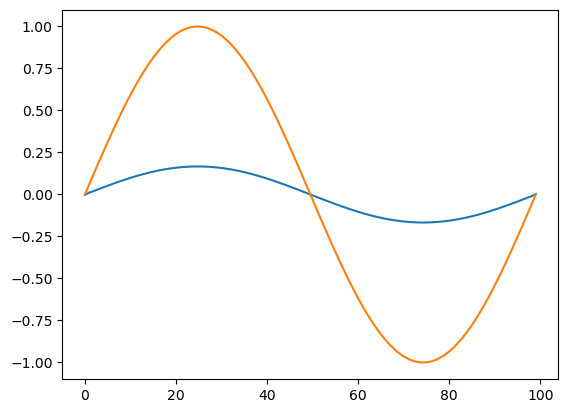

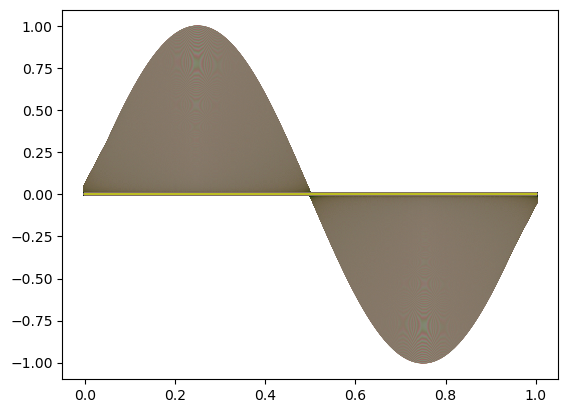

In [381]:
#kolokacijska metoda z B-zlepki
#vstavimo vsoto z zlepki v PDE in  upoštevamo robne pogoje, dobimo sisetm enačb za koeficiente, ki ga zapišemo v matrični obliki
#Po izpeljavi v navodilih:


D = 0.1 #difuzijska konstanta
N = 100 #velikost matrike
L = 1. #dolžina palice
x = np.linspace(0,L,N) #x_mreza
dx = x[1]-x[0]
t = np.arange(0,1,0.00001)
dt = t[1]-t[0]
k = 6. * D/ dx**2
A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
B = B * k
# print(A)
# print(B)

T_0 = np.sin(2*np.pi *x)
def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)

c0 = solve(A,T_0)
# print(c0)
plt.plot(c0)
# plt.plot(T_0)
plt.plot(A@c0)

ck = np.array(c0)
ck = c0
cks = []
for i in range(1,len(t)):
    ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
    cks.append(ck)

# def Bspline(x_2, x_1, x0,  x1, x2, x):
#     if x_2 <= x and x < x_1:
#         return (x-x_2)**3/dx**3
#     elif x_1 <= x and x < x0:
#         return (x-x_2)**3/dx**3 -4* (x-x_1)**3/dx**3 
#     elif x0 <= x and x < x1:
#         return (x2-x)**3/dx**3 -4* (x1-x)**3/dx**3
#     elif x1 <= x and x < x2:
#         return (x2-x)**3/dx**3
#     else:
#         return 0

# def Bspline(k, x):
#     x2 = x[k+2]    
#     x1 = x[k+1]
#     x0 = x[k]
#     x_1 = x[k-1]
#     x_2 = x[k-2]
#     if x_2 <= x and x < x_1:
#         return (x-x_2)**3/dx**3
#     elif x_1 <= x and x < x0:
#         return (x-x_2)**3/dx**3 -4* (x-x_1)**3/dx**3 
#     elif x0 <= x and x < x1:
#         return (x2-x)**3/dx**3 -4* (x1-x)**3/dx**3
#     elif x1 <= x and x < x2:
#         return (x2-x)**3/dx**3
#     else:
#         return 0


# x = np.linspace(0,L,N*3)
# res = np.ones_like(xm)

#gres po vsaki tocki iz mreze, in gledas za x-e znotrja usakega intervala in sestejes, tiste, ki so ustrezni

res= A @ ck
        

    # print(xm[np.where((xm-x2) * np.roll(xm,-1)-x2 < 0)])
plt.figure()
for ck in cks:
    res = A @ ck
    plt.plot(x,res)
    # print(res)
# plt.figure()
# plt.plot(c0)
# plt.figure()
# plt.plot(ck)
# plt.figure()
# plt.plot(res)




In [14]:
def solve_diffusion_E(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    Ts = []

    #EULER
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        Ts.append(np.real(T))
    

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        Ts_a.append(np.real(T))

    return Ts, [], Ts_a





    



/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1345726750.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


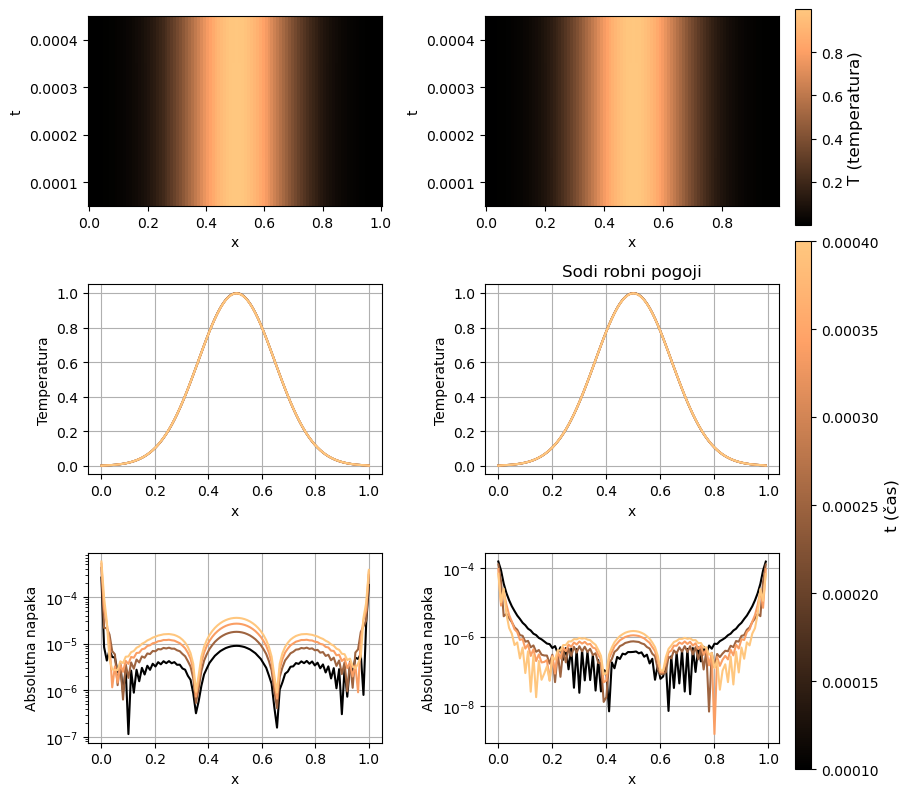

In [72]:
def solve_diffusion_B(D,T0,N,L,t):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """


    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#endpoint=False) # x coordinates
    dx=x[1]-x[0]
    k = 6. * D/ dx**2
    A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
    B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
    B = B * k

    c0 = solve(A,T0)
    # print(c0)
    # plt.plot(c0)
    # plt.plot(T_0)
    # plt.plot(A@c0)

    ck = np.array(c0)
    ck = c0
    cks = []
    dt = t[1]-t[0]
    for i in range(1,len(t)):
        ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
        cks.append(ck)

    Ts = []
    for ck in cks:
        res = A @ ck
        Ts.append(res)

    # print(np.shape(x))
    return Ts, x, cks



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)


def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,3,0.0001)
t = np.arange(0,0.0005,0.0001)

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots


# Euler:
res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, Ts_a = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[1,1].plot(x,Ts[ind],color=cmap(norm(ti)))
    # axs[1,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))
cax = fig.add_axes([1.0, 0.04, 0.02, 0.66])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[1,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[0,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.72, 0.02, 0.27])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)



#Bsplines:
res = solve_diffusion_B(D,T_0,N,L,t)
Ts, x, cks = res
# print(np.shape(Ts), np.shape(t[1:]), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[1,0].plot(x,Ts[ind],color=cmap(norm(ti)))
    # axs[1,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))


pcm = axs[0,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))

axs[1,0].set_title("")
axs[1,1].set_title("Sodi robni pogoji") 
axs[1,0].set_ylabel("Temperatura")
axs[1,1].set_ylabel("Temperatura")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[0,0].set_ylabel("t")
axs[0,1].set_ylabel("t")
axs[1,0].grid()
axs[1,1].grid()
axs[2,0].grid()
axs[2,1].grid()
axs[2,0].set_ylabel("Absolutna napaka")
axs[2,1].set_ylabel("Absolutna napaka")
axs[2,0].set_xlabel("x")
axs[2,1].set_xlabel("x")
axs[2,0].set_yscale('log')
axs[2,1].set_yscale('log')



# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
    



/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/1530063724.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


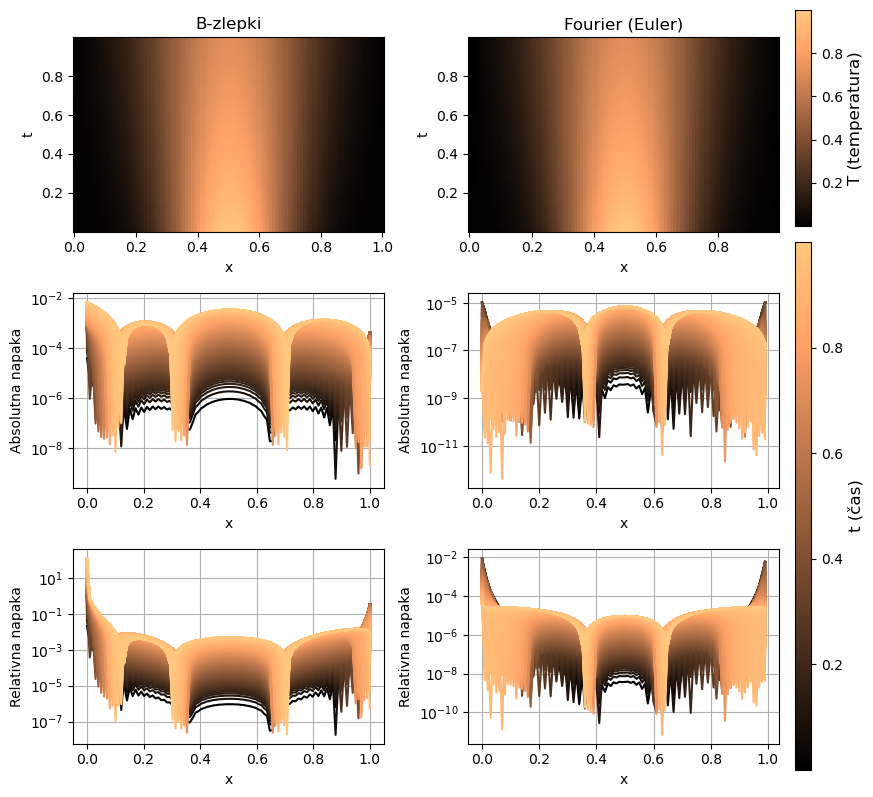

In [19]:
def solve_diffusion_B(D,T0,N,L,t):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """


    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#endpoint=False) # x coordinates
    dx=x[1]-x[0]
    k = 6. * D/ dx**2
    A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
    B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
    B = B * k

    c0 = solve(A,T0)
    # print(c0)
    # plt.plot(c0)
    # plt.plot(T_0)
    # plt.plot(A@c0)

    ck = np.array(c0)
    ck = c0
    cks = []
    dt = t[1]-t[0]
    for i in range(1,len(t)):
        ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
        cks.append(ck)

    Ts = []
    for ck in cks:
        res = A @ ck
        Ts.append(res)

    # print(np.shape(x))
    return Ts, x, cks



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.01  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)


def gauss(x, a, sig, amp):
    return amp*np.exp(-(x-a)**2/sig**2)
T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,0.0005,0.0001)
t = np.arange(0,1,0.0001)

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots


# Euler:
res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=False,shift=True)
Ts, cks, Ts_a = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    # axs[1,1].plot(x,Ts[ind],color=cmap(norm(ti)))
    axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,1].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))
cax = fig.add_axes([1.0, 0.04, 0.02, 0.66])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[1,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[0,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.72, 0.02, 0.27])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r'T (temperatura)', fontsize=12)



#Bsplines:
res = solve_diffusion_B(D,T_0,N,L,t)
Ts, x, cks = res
# print(np.shape(Ts), np.shape(t[1:]), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    # axs[1,0].plot(x,Ts[ind],color=cmap(norm(ti)))
    axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,0].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))


pcm = axs[0,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))

axs[0,0].set_title("B-zlepki")
axs[0,1].set_title("Fourier (Euler)") 
axs[2,0].set_ylabel("Relativna napaka")
axs[2,1].set_ylabel("Relativna napaka")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[2,0].set_xlabel("x")
axs[2,1].set_xlabel("x")
axs[0,0].set_ylabel("t")
axs[0,1].set_ylabel("t")
axs[2,0].grid()
axs[2,1].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,0].set_ylabel("Absolutna napaka")
axs[1,1].set_ylabel("Absolutna napaka")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[2,0].set_yscale('log')
axs[2,1].set_yscale('log')




# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
plt.savefig('B_euler2')



In [40]:
# stabilnost:
import time
Ds = [1., 0.1,0.01,0.001]
for D in Ds:
    N = 100
    L = 1.
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    # D = 0.1  

    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)

    # T_0 = gauss(x,0.5*L,0.2,1)

    # t = np.arange(0,0.0005,0.0001)
    # t = np.arange(0,3,0.0001)

    # fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

    Ns = np.arange(3,100,1)
    dts = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
    Ns = np.arange(10,50,2)
    # dts = [0.1,0.01,0.001,0.0001]
    #logarithmic scale of dts from 1e-1 to 1e-6
    dts = np.logspace(-1,-5,25)
    

    all_diff = []
    all_diff_r = []
    all_time = []
    for dt in dts:
        t = np.arange(0,1,dt)
        diff_t = []
        diff_t_r = []
        time_t = []
        for N in Ns:
            x=np.linspace(0,L,N)#endpoint=False)
            # x=np.linspace(0,L,N,endpoint=False)
            T_0 = gauss(x,0.5*L,0.2,1)

            start_time = time.time()
            res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=False,shift=True)
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_t.append(elapsed_time)
            Ts, cks, Ts_a = res
            if np.max(np.abs(Ts[-1] - Ts_a[-1])/np.abs(Ts_a[-1])) < 1e25:
                diff_t_r.append(np.max(np.abs(Ts[-1] - Ts_a[-1])/np.abs(Ts_a[-1])))
            else:
                diff_t_r.append(1e15)
            if np.max(np.abs(Ts[-1] - Ts_a[-1])) < 1e25:
                diff_t.append(np.max(np.abs(Ts[-1] - Ts_a[-1])))
            else:
                diff_t.append(1e15)
        all_diff.append(diff_t)
        all_diff_r.append(diff_t_r)
        all_time.append(time_t)
        print(dt)
    np.save("diffusion_stability" + f'{D}',all_diff)
    np.save("diffusion_stability_r" + f'{D}',all_diff_r)
    np.save("diffusion_stability_Ns" + f'{D}',Ns)
    np.save("diffusion_stability_dts" + f'{D}',dts)
    np.save("diffusion_stability_time" + f'{D}',all_time)
    print(D)



0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379
0.021544346900318846
0.014677992676220698


0.01


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3952360454.py:44: RuntimeWarning: overflow encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3952360454.py:44: RuntimeWarning: invalid value encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3952360454.py:48: RuntimeWarning: invalid value encountered in multiply
  T = (N * fft.ifft(cks[ind]))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/1020328483.py:47: RuntimeWarning: overflow encountered in divide
  if np.max(np.abs(Ts[-1] - Ts_a[-1])/np.abs(Ts_a[-1])) < 1e25:


0.006812920690579615
0.004641588833612782
0.0031622776601683794
0.0021544346900318843
0.0014677992676220704
0.001
0.0006812920690579615
0.0004641588833612782
0.00031622776601683794
0.00021544346900318845
0.00014677992676220705
0.0001
6.812920690579622e-05
4.641588833612782e-05
3.1622776601683795e-05
2.1544346900318867e-05
1.4677992676220705e-05
1e-05
1.0
0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379
0.021544346900318846
0.014677992676220698
0.01
0.006812920690579615
0.004641588833612782
0.0031622776601683794
0.0021544346900318843
0.0014677992676220704
0.001
0.0006812920690579615
0.0004641588833612782
0.00031622776601683794
0.00021544346900318845
0.00014677992676220705
0.0001
6.812920690579622e-05
4.641588833612782e-05
3.1622776601683795e-05
2.1544346900318867e-05
1.4677992676220705e-05
1e-05
0.1
0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379
0.021544346900318846
0.014677992676220698
0.01
0.006812920690579615
0.004641588833612782
0.003162277660168379

[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.     

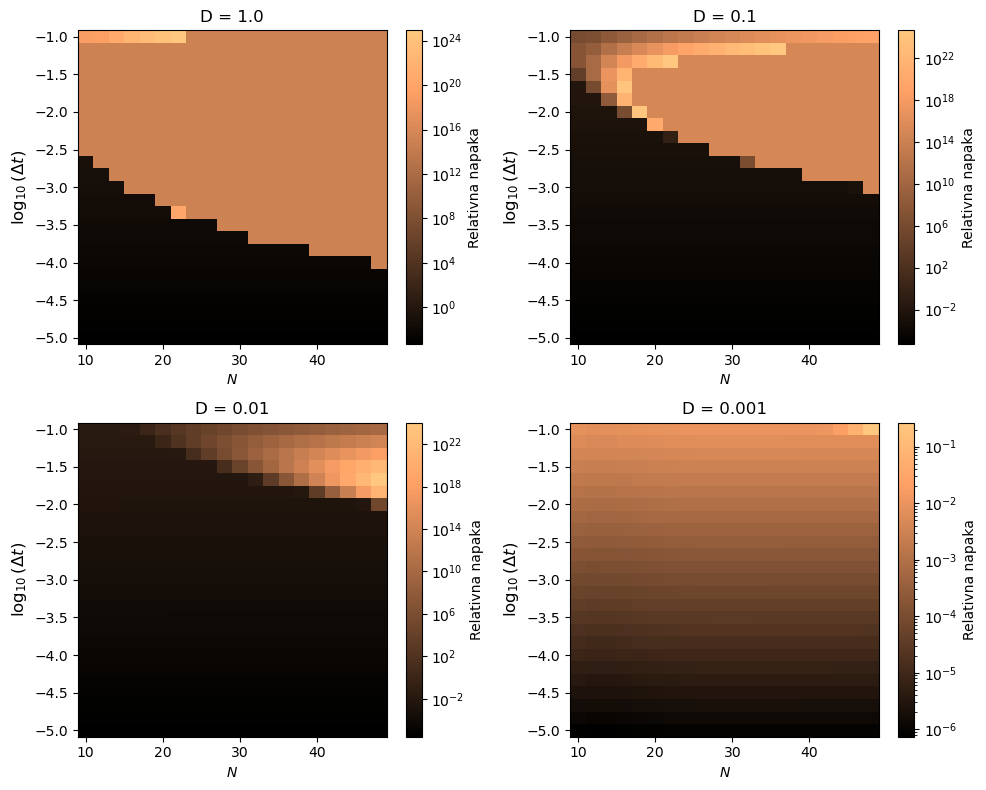

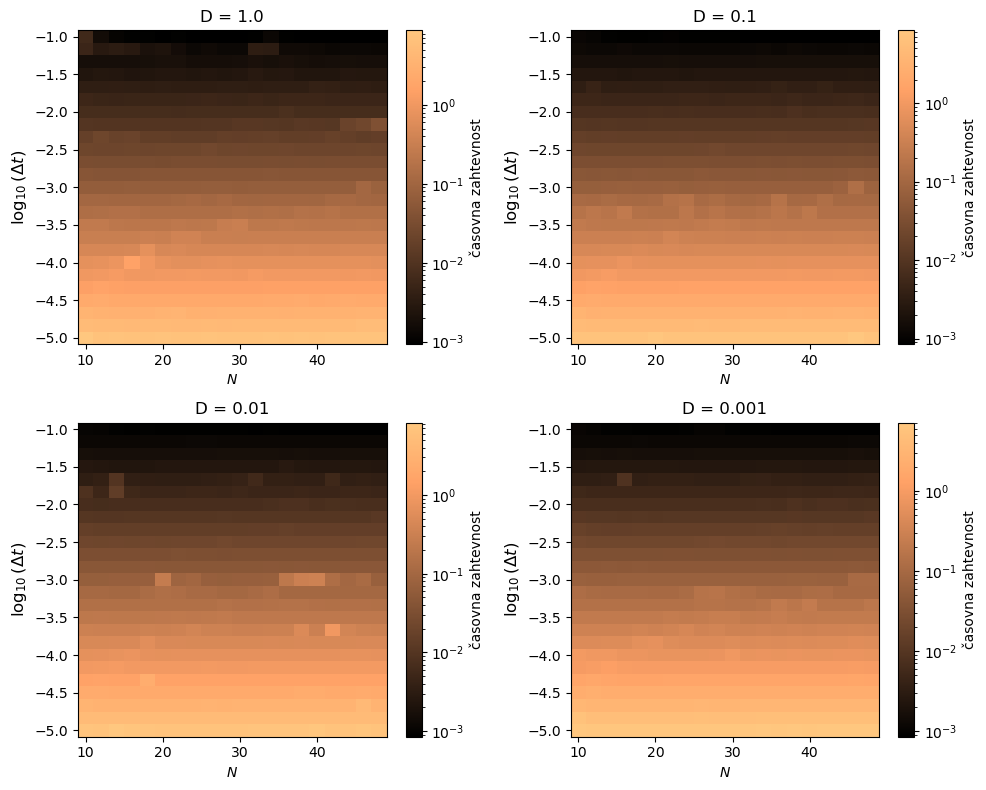

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("diffusion_stability" + f'{D}' + ".npy")
    Ns = np.load("diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Relativna napaka') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())
plt.tight_layout()
plt.savefig('absolutna_napaka_euler')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("diffusion_stability_r" + f'{D}' + ".npy")
    Ns = np.load("diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Relativna napaka') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('relativna_napaka_euler')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("diffusion_stability_time" + f'{D}' + ".npy")
    Ns = np.load("diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='časovna zahtevnost') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()


In [42]:
def solve_diffusion_RK(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    Ts = []

    #RK4
    def df(x, t):
        return -4 * np.pi**2 * D * fk**2 * x

    cks = rku4(df, T0_hat, t)

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        Ts.append(np.real(T))
    

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        Ts_a.append(np.real(T))

    return Ts, [], Ts_a




In [45]:
# stabilnost:
import time
Ds = [1., 0.1,0.01,0.001]
for D in Ds:
    N = 100
    L = 1.
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    # D = 0.1  

    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)

    # T_0 = gauss(x,0.5*L,0.2,1)

    # t = np.arange(0,0.0005,0.0001)
    # t = np.arange(0,3,0.0001)

    # fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

    Ns = np.arange(3,100,1)
    dts = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
    Ns = np.arange(10,100,4)
    # dts = [0.1,0.01,0.001,0.0001]
    #logarithmic scale of dts from 1e-1 to 1e-6
    dts = np.logspace(-1,-5,25)
    

    all_diff = []
    all_diff_r = []
    all_time = []
    for dt in dts:
        t = np.arange(0,1,dt)
        diff_t = []
        diff_t_r = []
        time_t = []
        for N in Ns:
            x=np.linspace(0,L,N)#endpoint=False)
            # x=np.linspace(0,L,N,endpoint=False)
            T_0 = gauss(x,0.5*L,0.2,1)

            start_time = time.time()
            res = solve_diffusion_RK(D,T_0,N,L,t,sodi_RP=False,shift=True)
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_t.append(elapsed_time)
            Ts, cks, Ts_a = res
            if np.max(np.abs(Ts[-1] - Ts_a[-1])/np.abs(Ts_a[-1])) < 1e25:
                diff_t_r.append(np.max(np.abs(Ts[-1] - Ts_a[-1])/np.abs(Ts_a[-1])))
            else:
                diff_t_r.append(1e15)
            if np.max(np.abs(Ts[-1] - Ts_a[-1])) < 1e25:
                diff_t.append(np.max(np.abs(Ts[-1] - Ts_a[-1])))
            else:
                diff_t.append(1e15)
        all_diff.append(diff_t)
        all_diff_r.append(diff_t_r)
        all_time.append(time_t)
        print(dt)
    np.save("RKdiffusion_stability" + f'{D}',all_diff)
    np.save("RKdiffusion_stability_r" + f'{D}',all_diff_r)
    np.save("RKdiffusion_stability_Ns" + f'{D}',Ns)
    np.save("RKdiffusion_stability_dts" + f'{D}',dts)
    np.save("RKdiffusion_stability_time" + f'{D}',all_time)
    print(D)


0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/350888436.py:42: RuntimeWarning: overflow encountered in multiply
  return -4 * np.pi**2 * D * fk**2 * x
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3364713989.py:35: RuntimeWarning: invalid value encountered in multiply
  k3 = h * f( x[i] + 0.5 * k2, t[i] + 0.5 * h )
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/350888436.py:42: RuntimeWarning: invalid value encountered in multiply
  return -4 * np.pi**2 * D * fk**2 * x
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3364713989.py:38: RuntimeWarning: invalid value encountered in multiply
  x[i+1] = x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3364713989.py:36: RuntimeWarning: invalid value encountered in multiply
  k4 = h * f( x[i] + k3, t[i+1] )
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_78164/3364713989.py:38: RuntimeWarning: invalid

0.021544346900318846
0.014677992676220698
0.01
0.006812920690579615
0.004641588833612782
0.0031622776601683794
0.0021544346900318843
0.0014677992676220704
0.001
0.0006812920690579615
0.0004641588833612782
0.00031622776601683794
0.00021544346900318845
0.00014677992676220705
0.0001
6.812920690579622e-05
4.641588833612782e-05
3.1622776601683795e-05
2.1544346900318867e-05
1.4677992676220705e-05
1e-05
1.0
0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379
0.021544346900318846
0.014677992676220698
0.01
0.006812920690579615
0.004641588833612782
0.0031622776601683794
0.0021544346900318843
0.0014677992676220704
0.001
0.0006812920690579615
0.0004641588833612782
0.00031622776601683794
0.00021544346900318845
0.00014677992676220705
0.0001
6.812920690579622e-05
4.641588833612782e-05
3.1622776601683795e-05
2.1544346900318867e-05
1.4677992676220705e-05
1e-05
0.1
0.1
0.06812920690579612
0.046415888336127795
0.03162277660168379
0.021544346900318846
0.014677992676220698
0.01
0.0068129206905

[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.         -2.16666667 -2.33333333 -2.5        -2.66666667 -2.83333333
 -3.         -3.16666667 -3.33333333 -3.5        -3.66666667 -3.83333333
 -4.         -4.16666667 -4.33333333 -4.5        -4.66666667 -4.83333333
 -5.        ]
[-1.         -1.16666667 -1.33333333 -1.5        -1.66666667 -1.83333333
 -2.     

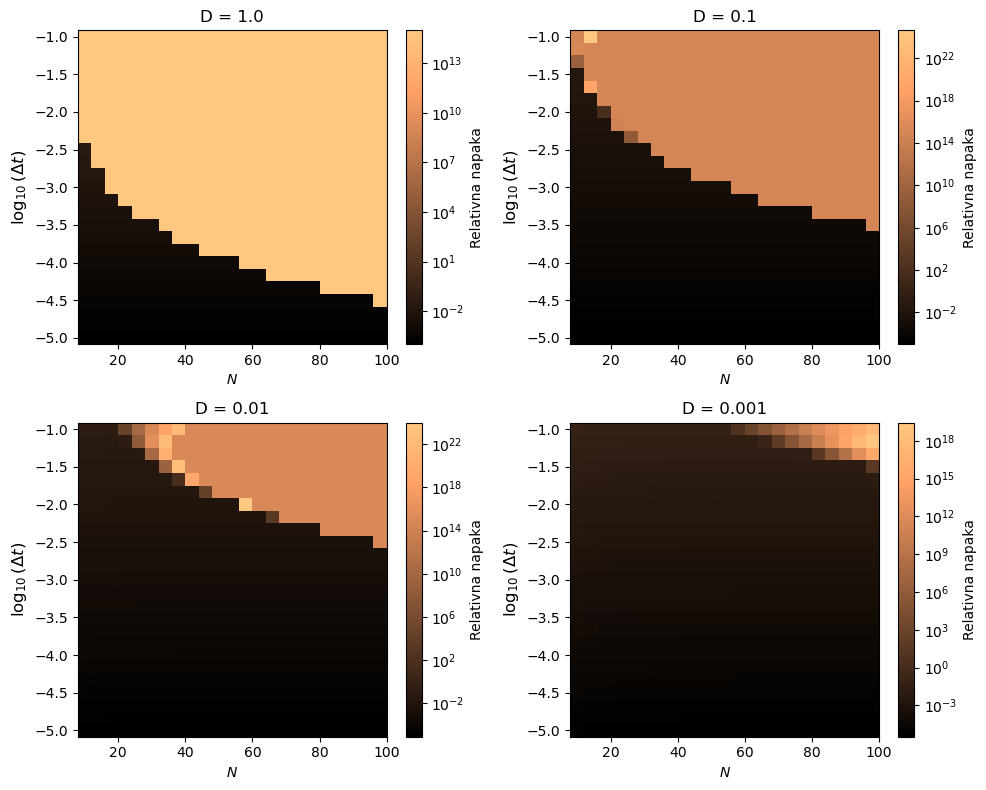

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("RKdiffusion_stability" + f'{D}' + ".npy")
    Ns = np.load("RKdiffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("RKdiffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Absolutna napaka') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('absolutna_napaka_RK')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("RKdiffusion_stability_r" + f'{D}' + ".npy")
    Ns = np.load("RKdiffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("RKdiffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Relativna napaka') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('relativna_napaka_RK')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("RKdiffusion_stability_time" + f'{D}' + ".npy")
    Ns = np.load("RKdiffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("RKdiffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Časovna zahtevnost') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()


In [46]:
def solve_diffusion_B(D,T0,N,L,t):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """


    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#endpoint=False) # x coordinates
    dx=x[1]-x[0]
    k = 6. * D/ dx**2
    A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
    B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
    B = B * k

    c0 = solve(A,T0)
    # print(c0)
    # plt.plot(c0)
    # plt.plot(T_0)
    # plt.plot(A@c0)

    ck = np.array(c0)
    ck = c0
    cks = []
    dt = t[1]-t[0]
    for i in range(1,len(t)):
        ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
        cks.append(ck)

    Ts = []
    for ck in cks:
        res = A @ ck
        Ts.append(res)

    # print(np.shape(x))
    return Ts, x, cks

def solve_diffusion_E(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    Ts = []

    #EULER
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        Ts.append(np.real(T))
    

    # #analytical solution:
    # Ts_a = []

    # for t1 in t[1:]:
    #     ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
    #     ck = T0_hat * ck_t
    #     T = (N * fft.ifft(ck))
    #     if shift == True:
    #         T = fft.ifftshift(T)
    #     if sodi_RP == False:
    #         T = T[:N//2]     
    #         x = x[:N//2]
    #     color = cmap(norm(t1))
    #     Ts_a.append(np.real(T))

    return Ts, [], []





    




In [48]:
# stabilnost:
import time
Ds = [1., 0.1,0.01,0.001]
for D in Ds:
    N = 100
    L = 1.
    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    # D = 0.1  

    def gauss(x, a, sig, amp):
        return amp*np.exp(-(x-a)**2/sig**2)

    # T_0 = gauss(x,0.5*L,0.2,1)

    # t = np.arange(0,0.0005,0.0001)
    # t = np.arange(0,3,0.0001)

    # fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

    Ns = np.arange(3,100,1)
    dts = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
    Ns = np.arange(10,100,4)
    # dts = [0.1,0.01,0.001,0.0001]
    #logarithmic scale of dts from 1e-1 to 1e-6
    dts = np.logspace(-3,-5,25)
    

    all_diff = []
    all_diff_r = []
    b_all_time = []
    e_all_time = []
    for dt in dts:
        t = np.arange(0,1,dt)
        diff_t = []
        diff_t_r = []
        e_time_t = []
        b_time_t = []
        for N in Ns:
            x=np.linspace(0,L,N)#endpoint=False)
            # x=np.linspace(0,L,N,endpoint=False)
            T_0 = gauss(x,0.5*L,0.2,1)

            start_time = time.time()
            res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=False,shift=False)
            end_time = time.time()
            elapsed_time = end_time - start_time
            e_time_t.append(elapsed_time)
            Ts_e, cks, Ts_a = res

            start_time = time.time()
            res = solve_diffusion_B(D,T_0,N,L,t)
            end_time = time.time()
            elapsed_time = end_time - start_time
            b_time_t.append(elapsed_time)
            Ts_b, cks, Ts_a = res
            if np.max(np.abs(Ts_e[-1] - Ts_b[-1])/np.abs(Ts_e[-1])) < 1e1:
                diff_t_r.append(np.max(np.abs(Ts_e[-1] - Ts_b[-1])/np.abs(Ts_e[-1])))
            else:
                diff_t_r.append(1e1)
            if np.max(np.abs(Ts_e[-1] - Ts_b[-1])) < 1e1:
                diff_t.append(np.max(np.abs(Ts_e[-1] - Ts_b[-1])))
            else:
                diff_t.append(1e1)
        all_diff.append(diff_t)
        all_diff_r.append(diff_t_r)
        b_all_time.append(b_time_t)
        e_all_time.append(e_time_t)
        print(dt)
    np.save("B_e_diffusion_stability" + f'{D}',all_diff)
    np.save("B_e_diffusion_stability_r" + f'{D}',all_diff_r)
    np.save("B_e_diffusion_stability_Ns" + f'{D}',Ns)
    np.save("B_e_diffusion_stability_dts" + f'{D}',dts)
    np.save("B_e_diffusion_stability_timeb" + f'{D}',b_all_time)
    np.save("B_e_diffusion_stability_timee" + f'{D}',e_all_time)
    print(D)


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/799693926.py:32: RuntimeWarning: overflow encountered in matmul
  ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/799693926.py:37: RuntimeWarning: overflow encountered in matmul
  res = A @ ck
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/799693926.py:37: RuntimeWarning: invalid value encountered in matmul
  res = A @ ck
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/799693926.py:86: RuntimeWarning: overflow encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/799693926.py:86: RuntimeWarning: invalid value encountered in multiply
  ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000

0.001
0.0008254041852680181
0.0006812920690579615
0.0005623413251903491
0.00046415888336127773
0.0003831186849557289
0.00031622776601683794
0.00026101572156825384
0.00021544346900318845
0.00017782794100389227
0.00014677992676220705
0.00012115276586285888
0.0001
8.25404185268019e-05
6.812920690579622e-05
5.623413251903491e-05
4.641588833612782e-05
3.831186849557293e-05
3.1622776601683795e-05
2.6101572156825386e-05
2.1544346900318867e-05
1.778279410038923e-05
1.4677992676220705e-05
1.2115276586285901e-05
1e-05
1.0
0.001
0.0008254041852680181
0.0006812920690579615
0.0005623413251903491
0.00046415888336127773
0.0003831186849557289
0.00031622776601683794
0.00026101572156825384
0.00021544346900318845
0.00017782794100389227
0.00014677992676220705
0.00012115276586285888
0.0001
8.25404185268019e-05
6.812920690579622e-05
5.623413251903491e-05
4.641588833612782e-05
3.831186849557293e-05
3.1622776601683795e-05
2.6101572156825386e-05
2.1544346900318867e-05
1.778279410038923e-05
1.4677992676220705e-

[[6.54481704e-04 2.96541229e-04 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01]
 [6.54480221e-04 2.96666529e-04 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01]
 [6.56937226e-04 2.98002334e-04 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00000000e+01 1.00000000e+01
  1.00000000e+01 1.00000000e+01 1.00

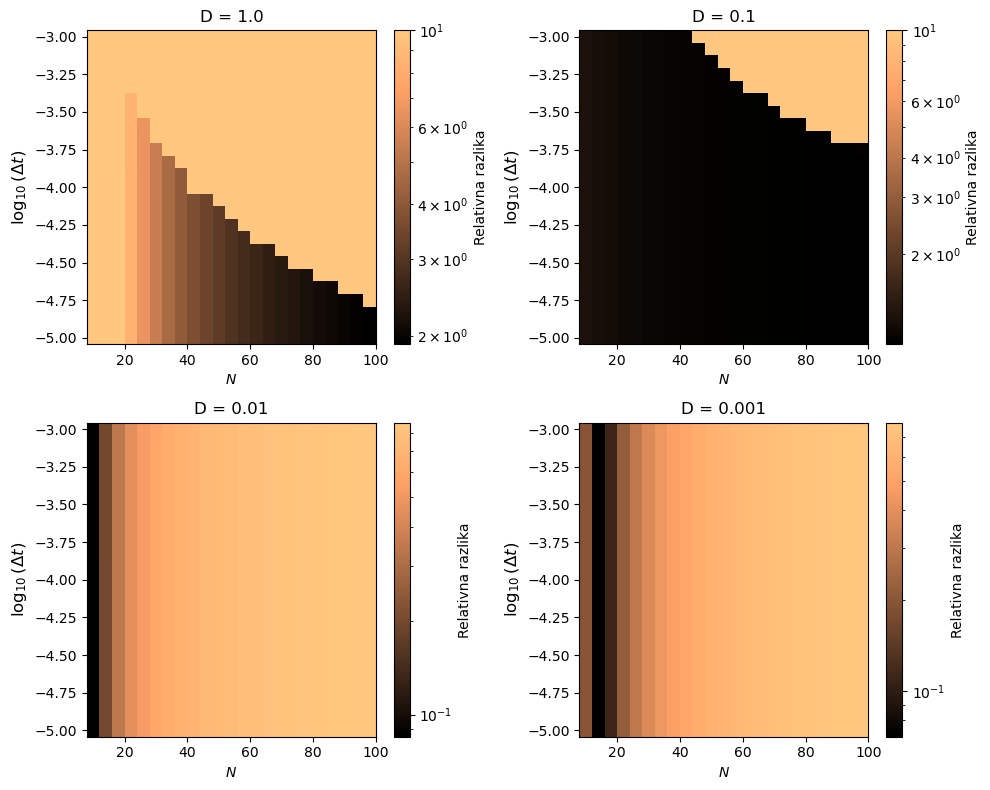

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("B_e_diffusion_stability" + f'{D}' + ".npy")
    print(diff)
    Ns = np.load("B_e_diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("B_e_diffusion_stability_dts" + f'{D}' + ".npy")
    print(dts)
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Absolutna razlika') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('absolutna_razlika')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("B_e_diffusion_stability_r" + f'{D}' + ".npy")
    Ns = np.load("B_e_diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("B_e_diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Relativna razlika') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('relativna_razlika')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("B_e_diffusion_stability_timee" + f'{D}' + ".npy")
    Ns = np.load("B_e_diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("B_e_diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Časovna zahtevnost') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('casovna_zahetnost_euler')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column of subplots
D = 0.1
Ds = [1., 0.1,0.01,0.001]

indices = [(0,0),(0,1),(1,0),(1,1)]
for D,ind in zip(Ds,indices):
    diff = np.load("B_e_diffusion_stability_timeb" + f'{D}' + ".npy")
    Ns = np.load("B_e_diffusion_stability_Ns" + f'{D}' + ".npy")
    dts = np.load("B_e_diffusion_stability_dts" + f'{D}' + ".npy")
    dts = np.log10(dts)
    # print(dts)
    # print(all_diff)
    x_mesh, t_mesh = np.meshgrid(Ns,dts)
    # print(t_mesh)
    # print(np.shape(all_diff), np.shape(x_mesh), np.shape(t_mesh))
    print(dts)
    pcm = axs[ind].pcolormesh(Ns,dts, diff, cmap='copper', norm=LogNorm(vmin=np.min(diff), vmax=np.max(diff)))
    plt.colorbar(pcm, label='Časovna zahtevnost') 
    axs[ind].set_title("D = " + f'{D}')
    axs[ind].set_ylabel(r"$\log_{10}(\Delta t)$", fontsize= 12)
    axs[ind].set_xlabel(r"$N$")
    # axs[ind].set_yscale("log")
    # axs[ind].set_yticks(np.logspace((min(dts)),(max(dts)), num=len(dts)))
    # axs[ind].get_yaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('casovna_zahetnost_b')

/Users/lukapuslar/miniconda3/envs/torch_m1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/3025372864.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


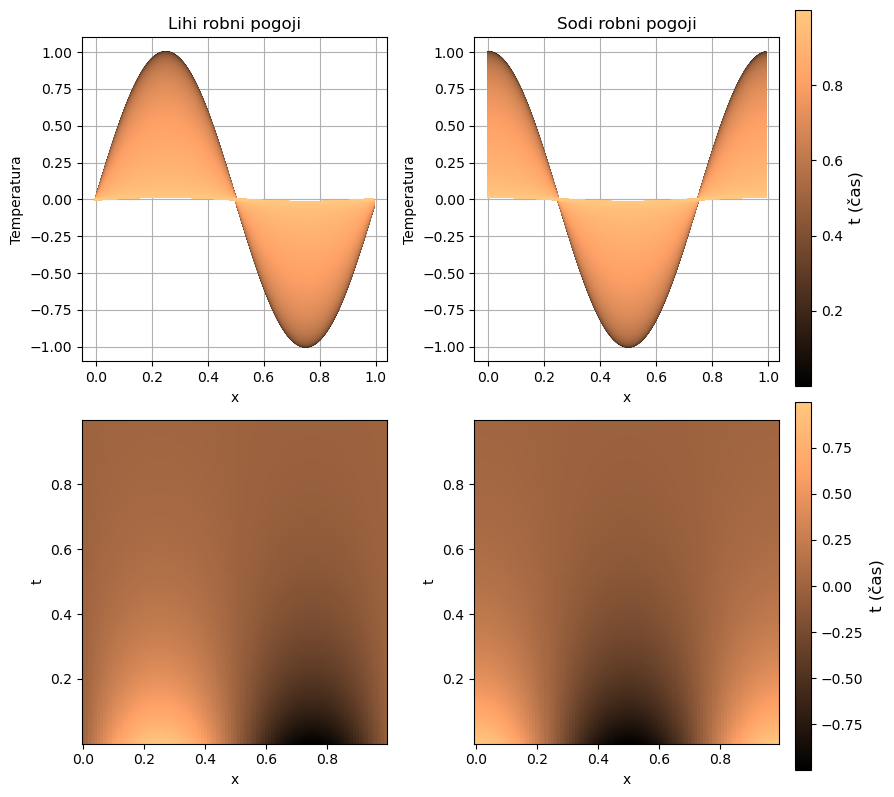

In [11]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        # T_0 = fft.fft(fft.ifftshift(T_0))/N # Fourier coefficients (divided by n), correctly shifted
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    # norm = Normalize(vmin=min(t), vmax=max(t))
    norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
    cks = []
    colors = []
    Ts = []
    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        cks.append(ck)
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
    return Ts, cks, colors



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)

# def gauss(x, a, sig, amp):
#     return amp*np.exp(-(x-a)**2/sig**2)
# T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,1,0.0001)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

#lihi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=colors[ind])
# cax = fig.add_axes([0.5, 0.5, 0.02, 0.5])

# cmap = plt.get_cmap("copper")
# norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
# cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,0],location='right')
# cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
# cax = fig.add_axes([0.5, 0.0, 0.02, 0.5])

# cmap = plt.get_cmap("copper")
# norm = LogNorm(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
# cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')

T_0 = np.cos(2*np.pi *x)
#sodi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts[ind],color=colors[ind])
cax = fig.add_axes([1.0, 0.52, 0.02, 0.47])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.04, 0.02, 0.46])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

axs[0,0].set_title("Lihi robni pogoji")
axs[0,1].set_title("Sodi robni pogoji") 
axs[0,0].set_ylabel("Temperatura")
axs[0,1].set_ylabel("Temperatura")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[1,0].set_ylabel("t")
axs[1,1].set_ylabel("t")
axs[0,0].grid()
axs[0,1].grid()


# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
# plt.savefig("lihi_sodi_rp", bbox_inches="tight")



/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/1090695371.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


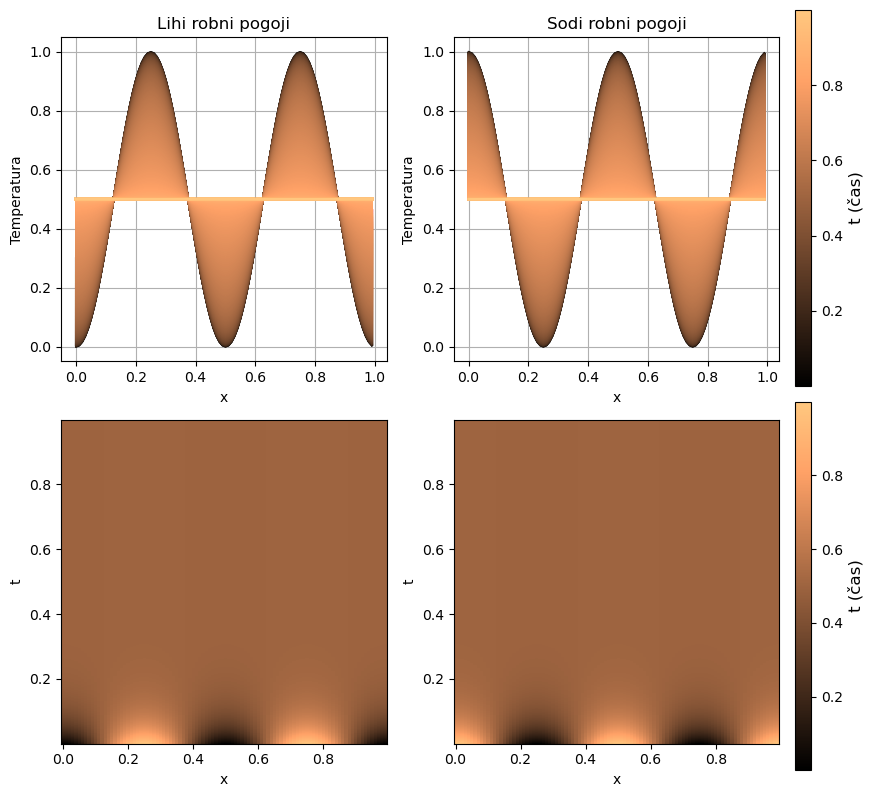

In [12]:
def solve_diffusion(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        # T_0 = fft.fft(fft.ifftshift(T_0))/N # Fourier coefficients (divided by n), correctly shifted
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    # norm = Normalize(vmin=min(t), vmax=max(t))
    norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
    cks = []
    colors = []
    Ts = []
    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        cks.append(ck)
        colors.append(color)
        Ts.append(T)

        # plt.plot(x,T,color=color)
    return Ts, cks, colors



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)**2

# def gauss(x, a, sig, amp):
#     return amp*np.exp(-(x-a)**2/sig**2)
# T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,1,0.0001)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots

#lihi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=colors[ind])
# cax = fig.add_axes([0.5, 0.5, 0.02, 0.5])

# cmap = plt.get_cmap("copper")
# norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
# cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,0],location='right')
# cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,0].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
# cax = fig.add_axes([0.5, 0.0, 0.02, 0.5])

# cmap = plt.get_cmap("copper")
# norm = LogNorm(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
# cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')

T_0 = np.cos(2*np.pi *x)**2
#sodi rp:
res = solve_diffusion(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, colors = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts[ind],color=colors[ind])
cax = fig.add_axes([1.0, 0.52, 0.02, 0.47])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

pcm = axs[1,1].pcolormesh(x_mesh,t_mesh, np.real(Ts), cmap='copper', norm=Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts))))
# plt.colorbar(pcm, label='T(x,t)') 
cax = fig.add_axes([1.0, 0.04, 0.02, 0.46])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=np.min(np.real(Ts)), vmax=np.max(np.real(Ts)))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[0,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)

axs[0,0].set_title("Lihi robni pogoji")
axs[0,1].set_title("Sodi robni pogoji") 
axs[0,0].set_ylabel("Temperatura")
axs[0,1].set_ylabel("Temperatura")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[1,0].set_ylabel("t")
axs[1,1].set_ylabel("t")
axs[0,0].grid()
axs[0,1].grid()


# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
# plt.savefig("lihi_sodi_rp", bbox_inches="tight")



(9999, 100) (9999, 100)


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/4116499663.py:146: RuntimeWarning: divide by zero encountered in divide
  axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/4116499663.py:146: RuntimeWarning: invalid value encountered in divide
  axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/4116499663.py:176: RuntimeWarning: divide by zero encountered in divide
  axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/4116499663.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


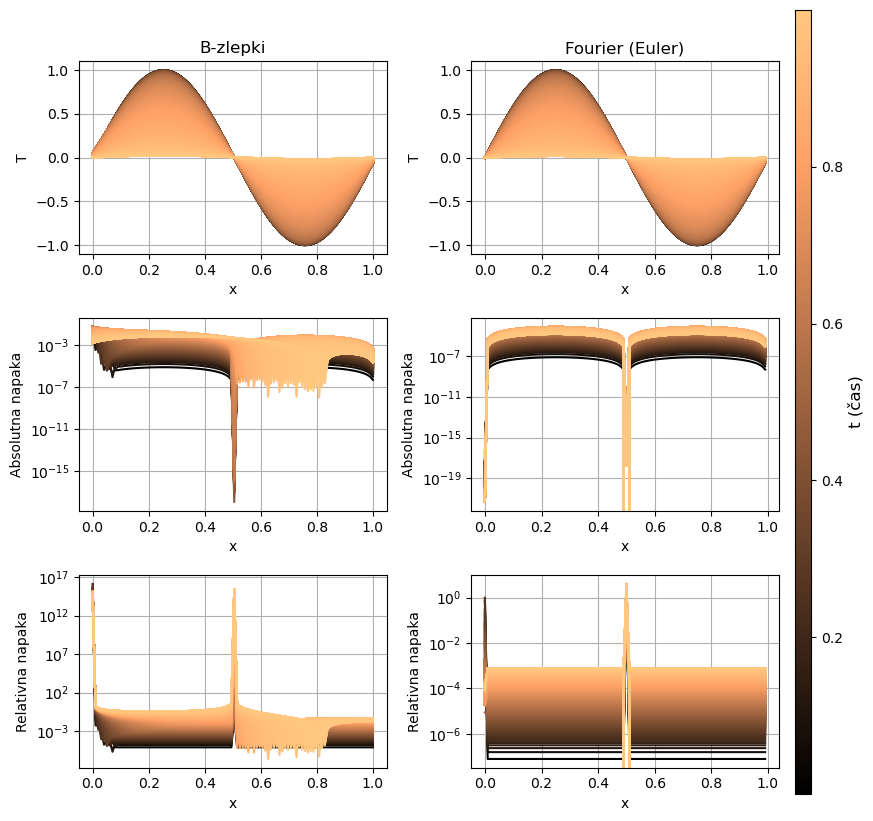

In [41]:
def solve_diffusion_E(D,T0,N,L,t,sodi_RP=True,shift=False):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """

    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    if sodi_RP == False:
        T0 = np.concatenate((T0,-T0))  
        L = 2*L
        N = 2*N
        x=np.linspace(0,L,N,endpoint=False) # x coordinates

    delta=L/N
    nu = fft.fftfreq(N,delta) # Natural frequencies  -> tuki znotrej je 2*pi
    # nu = fft.fftshift(nu) # Shift frequencies to match fft
    dx = x[1]-x[0] 
    dt = t[1]-t[0]

    if shift == True:
        T0 = fft.ifftshift(T0)
    def transf_T_0(T_0):
        T_0 = fft.fft(T_0)/N # Fourier coefficients (divided by n), correctly shifted
        return T_0

    T0_hat = transf_T_0(T0)
    fk = nu 
    cmap = plt.get_cmap("copper")
    norm = Normalize(vmin=min(t), vmax=max(t))
    # norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))

    cks = []
    Ts = []

    #EULER
    ck = T0_hat
    # print(np.shape(ck), np.shape(fk))
    for t1 in t:
        ck = ck + dt * (-4 * np.pi**2 * D * fk**2 * ck)  #za velike N divergira metoda preveri stabilnost eulerja
        cks.append(ck)

    for ind,t1 in enumerate(t[1:]):
        T = (N * fft.ifft(cks[ind]))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        Ts.append(np.real(T))
    

    #analytical solution:
    Ts_a = []

    for t1 in t[1:]:
        ck_t = np.exp(-4 * np.pi**2 * D * fk**2 * t1)
        ck = T0_hat * ck_t
        T = (N * fft.ifft(ck))
        if shift == True:
            T = fft.ifftshift(T)
        if sodi_RP == False:
            T = T[:N//2]     
            x = x[:N//2]
        color = cmap(norm(t1))
        Ts_a.append(np.real(T))
    print(np.shape(Ts),np.shape(Ts_a)) 
    return Ts, [], Ts_a


def solve_diffusion_B(D,T0,N,L,t):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """


    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#endpoint=False) # x coordinates
    dx=x[1]-x[0]
    k = 6. * D/ dx**2
    A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
    B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
    B = B * k

    c0 = solve(A,T0)
    # print(c0)
    # plt.plot(c0)
    # plt.plot(T_0)
    # plt.plot(A@c0)

    ck = np.array(c0)
    ck = c0
    cks = []
    dt = t[1]-t[0]
    for i in range(1,len(t)):
        ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
        cks.append(ck)

    Ts = []
    for ck in cks:
        res = A @ ck
        Ts.append(res)

    # print(np.shape(x))
    return Ts, x, cks



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
T_0 = np.sin(2*np.pi *x)


# def gauss(x, a, sig, amp):
#     return amp*np.exp(-(x-a)**2/sig**2)
# T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,0.0005,0.0001)
t = np.arange(0,1,0.0001)

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots


# Euler:
res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=True,shift=False)
Ts, cks, Ts_a = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts_a[ind],color=cmap(norm(ti)))
    axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,1].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))
cax = fig.add_axes([1.0, 0.04, 0.02, 0.98])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[1,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)




#Bsplines:
res = solve_diffusion_B(D,T_0,N,L,t)
Ts, x, cks = res
# print(np.shape(Ts), np.shape(t[1:]), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=cmap(norm(ti)))
    axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,0].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))




axs[0,0].set_title("B-zlepki")
axs[0,1].set_title("Fourier (Euler)") 
axs[2,0].set_ylabel("Relativna napaka")
axs[2,1].set_ylabel("Relativna napaka")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[2,0].set_xlabel("x")
axs[2,1].set_xlabel("x")
axs[0,0].set_ylabel("T")
axs[0,1].set_ylabel("T")
axs[2,0].grid()
axs[2,1].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].set_ylabel("Absolutna napaka")
axs[1,1].set_ylabel("Absolutna napaka")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[2,0].set_yscale('log')
axs[2,1].set_yscale('log')




# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
plt.savefig('sinus', bbox_inches="tight")



(9999, 100) (9999, 100)


/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/804784455.py:72: RuntimeWarning: divide by zero encountered in divide
  axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/804784455.py:72: RuntimeWarning: invalid value encountered in divide
  axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/804784455.py:102: RuntimeWarning: divide by zero encountered in divide
  axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
/var/folders/1l/8qyzjsmx231gm5fbpjts8n6c0000gn/T/ipykernel_17594/804784455.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


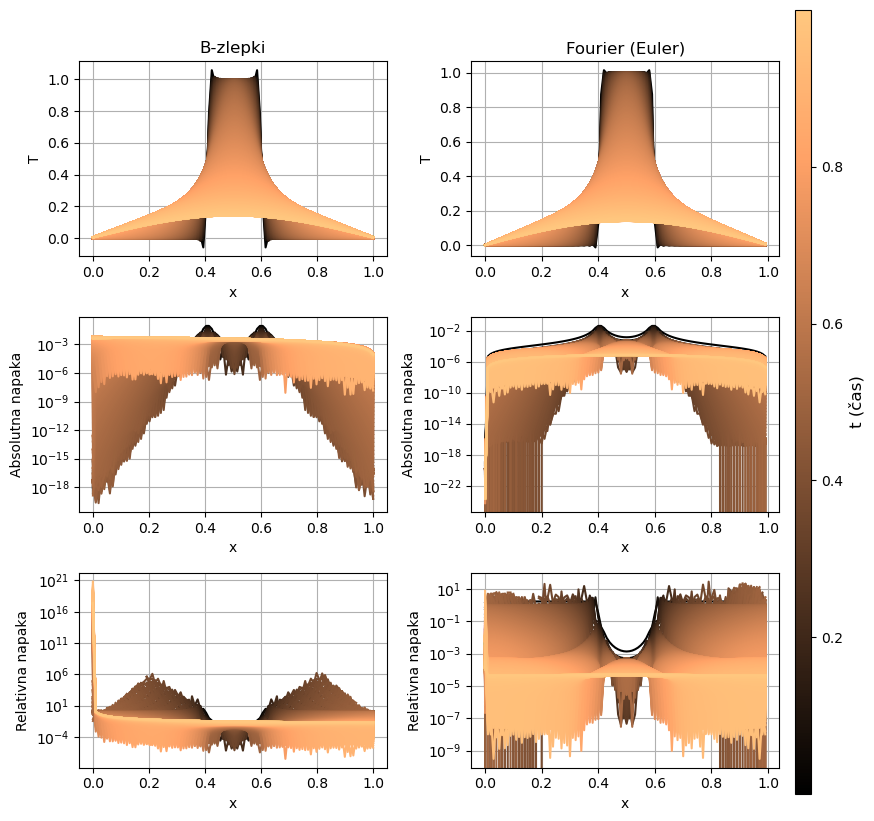

In [40]:
def solve_diffusion_B(D,T0,N,L,t):
    """
    D is the diffusion coefficient
    T_0 is the initial temperature distribution
    x is the spatial grid
    T is the temperature distribution after one time step
    N is the number of time steps
    L is the length of the spatial grid
    t is the time grid
    """


    x=np.linspace(0,L,N,endpoint=False) # x coordinates
    x=np.linspace(0,L,N)#endpoint=False) # x coordinates
    dx=x[1]-x[0]
    k = 6. * D/ dx**2
    A = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * 4)
    B = np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N) * -2)
    B = B * k

    c0 = solve(A,T0)
    # print(c0)
    # plt.plot(c0)
    # plt.plot(T_0)
    # plt.plot(A@c0)

    ck = np.array(c0)
    ck = c0
    cks = []
    dt = t[1]-t[0]
    for i in range(1,len(t)):
        ck = (np.eye(len(ck)) + dt * la.inv(A) @ B) @ ck
        cks.append(ck)

    Ts = []
    for ck in cks:
        res = A @ ck
        Ts.append(res)

    # print(np.shape(x))
    return Ts, x, cks



N = 100
L = 1
x=np.linspace(0,L,N,endpoint=False) # x coordinates
D = 0.1  
T_0 = np.zeros(N)
T_0[np.where((x>0.4) & (x<0.6))] = 1
# T_0 = np.sin(2*np.pi *x)


# def gauss(x, a, sig, amp):
#     return amp*np.exp(-(x-a)**2/sig**2)
# T_0 = gauss(x,0.5*L,0.2,1)

t = np.arange(0,0.0005,0.0001)
t = np.arange(0,1,0.0001)

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 1 column of subplots


# Euler:
res = solve_diffusion_E(D,T_0,N,L,t,sodi_RP=False,shift=False)
Ts, cks, Ts_a = res
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[0,1].plot(x,Ts_a[ind],color=cmap(norm(ti)))
    axs[2,1].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,1].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))
cax = fig.add_axes([1.0, 0.04, 0.02, 0.98])

cmap = plt.get_cmap("copper")
norm = Normalize(vmin=min(t[1:]), vmax=max(t[1:]))
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),cax=cax, ax=axs[1,1],location='right')
cbar.set_label(r't (čas)', fontsize=12)



#Bsplines:
res = solve_diffusion_B(D,T_0,N,L,t)
Ts, x, cks = res
# print(np.shape(Ts), np.shape(t[1:]), np.shape(x))
# print(Ts)
x_mesh, t_mesh = np.meshgrid(x,t[1:])
cmap = plt.get_cmap("copper")
norm = LogNorm(vmin=min(t[1:]), vmax=max(t[1:]))
for ind,ti in enumerate(t[1:]):
    axs[0,0].plot(x,Ts[ind],color=cmap(norm(ti)))
    axs[2,0].plot(x,np.abs(Ts[ind]-Ts_a[ind])/np.abs(Ts_a[ind]),color=cmap(norm(ti)))
    axs[1,0].plot(x,np.abs(Ts[ind]-Ts_a[ind]),color=cmap(norm(ti)))


axs[0,0].set_title("B-zlepki")
axs[0,1].set_title("Fourier (Euler)") 
axs[2,0].set_ylabel("Relativna napaka")
axs[2,1].set_ylabel("Relativna napaka")
axs[0,0].set_xlabel("x")
axs[0,1].set_xlabel("x")
axs[2,0].set_xlabel("x")
axs[2,1].set_xlabel("x")
axs[0,0].set_ylabel("T")
axs[0,1].set_ylabel("T")
axs[2,0].grid()
axs[2,1].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].set_ylabel("Absolutna napaka")
axs[1,1].set_ylabel("Absolutna napaka")
axs[1,0].set_xlabel("x")
axs[1,1].set_xlabel("x")
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[2,0].set_yscale('log')
axs[2,1].set_yscale('log')




# plt.figure()
# solve_diffusion(D,T_0,N,L,t,sodi_RP=False)
plt.tight_layout()
plt.savefig('box',bbox_inches='tight')

#uporabljen endpoint=false, da so iste dimenzije za B_zlepke -> zato imamo nesimetrično